In [1]:
!pip install einops
!pip install timm
!pip install peft
!pip install roboflow git+https://github.com/roboflow/supervision.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
torch.cuda.is_available()

True

In [4]:
# @title Imports

import io
import os
import re
import json
import torch
import html
import base64
import itertools

import numpy as np
import supervision as sv

from IPython.display import display, HTML
from torch.utils.data import Dataset, DataLoader
from transformers import (
    # AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Generator
from peft import LoraConfig, get_peft_model
from PIL import Image
from roboflow import Roboflow
from peft import PeftModel

Load the model using `AutoModelForCausalLM` and the processor using `AutoProcessor` classes from the transformers library. Note that you need to pass `trust_remote_code` as `True` since this model is not a standard transformers model.

In [5]:
# Constants
MODEL_PATH = "/content/florence2"# Update with actual model path
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Define paths
base_model_id = "microsoft/Florence-2-base-ft"  # Base model used for LoRA fine-tuning

# Enable trust_remote_code to avoid prompts
processor = AutoProcessor.from_pretrained(MODEL_PATH, trust_remote_code=True)

# Load the base model
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    trust_remote_code=True,
    revision="refs/pr/6"
).to(DEVICE)

# Load the fine-tuned LoRA model from the saved directory
peft_model = PeftModel.from_pretrained(base_model, MODEL_PATH).to(DEVICE)

# Optional: Print model device placement
print("PEFT Model loaded and placed on:", next(peft_model.parameters()).device)


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

Importing from timm.models.layers is deprecated, please import via timm.layers


pytorch_model.bin:   0%|          | 0.00/464M [00:00<?, ?B/s]

Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


PEFT Model loaded and placed on: cuda:0


In [45]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Npr82rgYiQ5A5trJBlb8")
project = rf.workspace("capstone2025-mifho").project("military-base-object-detection")
version = project.version(13)
dataset = version.download("florence2-od")


loading Roboflow workspace...
loading Roboflow project...
Exporting format florence2-od in progress : 85.0%
Version export complete for florence2-od format



Extracting Dataset Version Zip to Military-Base-Object-Detection-13 in florence2-od:: 100%|██████████| 12101/12101 [00:09<00:00, 1321.40it/s]


In [8]:
# @title Define `DetectionsDataset` class

class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self) -> List[Dict[str, Any]]:
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        try:
            image = Image.open(image_path)
            return (image, entry)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")


class DetectionDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = data['prefix']
        suffix = data['suffix']
        return prefix, suffix, image

In [46]:
# @title Initiate `DetectionsDataset` and `DataLoader` for train and validation subsets

BATCH_SIZE = 4
NUM_WORKERS = 0

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
    return inputs, answers

val_dataset = DetectionDataset(
    jsonl_file_path = f"{dataset.location}/valid/annotations.jsonl",
    image_directory_path = f"{dataset.location}/valid/"
)
test_dataset = DetectionDataset(
    jsonl_file_path = f"{dataset.location}/test/annotations.jsonl",
    image_directory_path = f"{dataset.location}/test/"
)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)

In [10]:
torch.cuda.empty_cache()

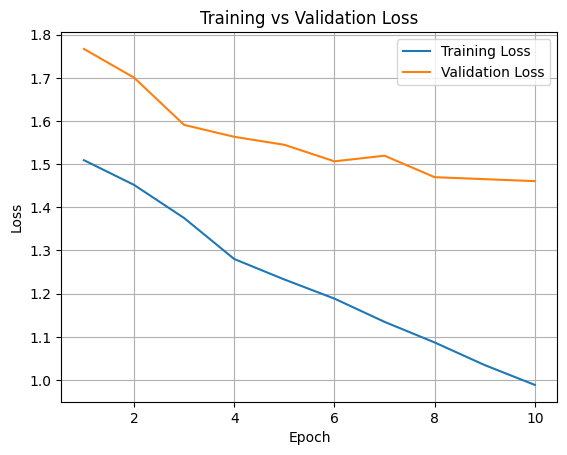

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 11))
train_loss = [1.509146496, 1.451913585, 1.375092581, 1.280150507, 1.232772345,
              1.188435142, 1.1345855, 1.086884382, 1.034384113, 0.988501778]
val_loss = [1.766913983, 1.700414191, 1.590892504, 1.563305358, 1.544828533,
            1.506496092, 1.519515001, 1.469803361, 1.465170792, 1.460625875]

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


## Fine-tuned model evaluation

**NOTE:** It seems that the model can still detect classes that don't belong to our custom dataset.

In [11]:
# @title Collect predictions

PATTERN = r'([A-Za-z]+(-[A-Za-z]+)*)<loc_\d+>'

def extract_classes(dataset: DetectionDataset):
    class_set = set()
    for i in range(len(dataset.dataset)):
        image, data = dataset.dataset[i]
        suffix = data["suffix"]
        classes = re.findall(PATTERN, suffix)
        # print(classes)
        class_set.update(classes)
    return sorted(class_set)

CLASSES = extract_classes(test_dataset)



In [12]:
print(CLASSES)

[('Aircraft', ''), ('Camouflage', ''), ('Drone', ''), ('Fire', ''), ('Grenade', ''), ('Hand-Gun', '-Gun'), ('Knife', ''), ('Military-Vehicle', '-Vehicle'), ('Missile', ''), ('Pistol', ''), ('Rifle', ''), ('Smoke', ''), ('Soldier', '')]


In [13]:
CLASSES = [cls[0] for cls in CLASSES]

In [14]:
print(CLASSES)

['Aircraft', 'Camouflage', 'Drone', 'Fire', 'Grenade', 'Hand-Gun', 'Knife', 'Military-Vehicle', 'Missile', 'Pistol', 'Rifle', 'Smoke', 'Soldier']


# Validation Dataset

In [47]:
from tqdm import tqdm  # Progress bar

targets = []
predictions = []

# Iterate over the dataset with a progress bar
for i in tqdm(range(len(val_dataset.dataset)), desc="Evaluating Model", unit="image"):
    try:
        image, data = val_dataset.dataset[i]
        prefix = data['prefix']
        suffix = data['suffix']  # Ground truth annotation

        # Prepare input for the model
        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
        generated_ids = peft_model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

        # Process model prediction
        prediction = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
        prediction = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, prediction, resolution_wh=image.size)
        prediction = prediction[np.isin(prediction['class_name'], CLASSES)]

        prediction.class_id = np.array([CLASSES.index(class_name) for class_name in prediction['class_name']])
        prediction.confidence = np.ones(len(prediction))

        target = processor.post_process_generation(suffix, task='<OD>', image_size=image.size)
        target = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, target, resolution_wh=image.size)
        target.class_id = np.array([CLASSES.index(class_name) for class_name in target['class_name']])
        targets.append(target)
        predictions.append(prediction)

    except Exception as e:
        print(f"Error processing index {i}: {e}")

# Print summary
print(f"\nProcessed {len(targets)} samples successfully.")


Evaluating Model:   0%|          | 0/2245 [00:00<?, ?image/s]from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
Evaluating Model:   0%|          | 1/2245 [00:01<39:06,  1.05s/image]from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
Evaluating Model:   0%|          | 2/2245 [00:01<23:50,  1.57image/s]from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecat


Processed 2245 samples successfully.


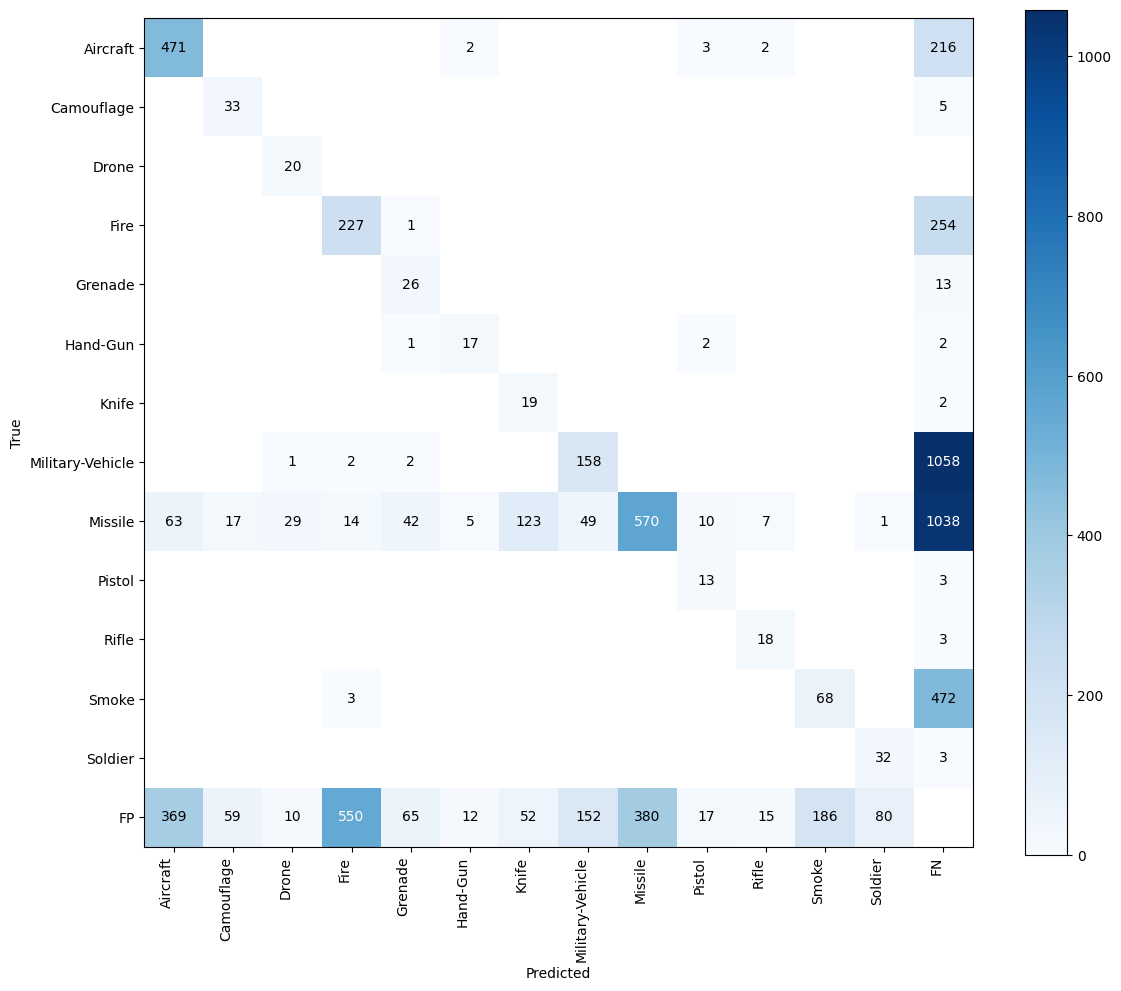

In [49]:
# @title Calculate Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

_ = confusion_matrix.plot()

In [69]:
def calculate_per_class_map50(predictions, targets, classes):
    per_class_map50 = {}

    for class_idx, class_name in enumerate(classes):
        class_preds = []
        class_targets = []

        for pred, tgt in zip(predictions, targets):
            pred_mask = pred.class_id == class_idx
            tgt_mask = tgt.class_id == class_idx

            class_preds.append(pred[pred_mask])
            class_targets.append(tgt[tgt_mask])

        # Compute mAP only at IoU 0.5
        class_map = sv.MeanAveragePrecision.from_detections(
            predictions=class_preds,
            targets=class_targets
        )

        per_class_map50[class_name] = class_map.map50

    return per_class_map50

per_class_map50 = calculate_per_class_map50(predictions, targets, CLASSES)

print("\n--- Per-Class mAP@50 ---")
for class_name, map50 in per_class_map50.items():
    print(f"Class: {class_name:15s} | mAP@50: {map50:.5f}")


--- Per-Class mAP@50 ---
Class: Aircraft        | mAP@50: 0.65448
Class: Camouflage      | mAP@50: 0.92771
Class: Drone           | mAP@50: 0.99500
Class: Fire            | mAP@50: 0.25393
Class: Grenade         | mAP@50: 0.82040
Class: Hand-Gun        | mAP@50: 0.88632
Class: Knife           | mAP@50: 0.94039
Class: Military-Vehicle | mAP@50: 0.36222
Class: Missile         | mAP@50: 0.39257
Class: Pistol          | mAP@50: 0.90620
Class: Rifle           | mAP@50: 0.92850
Class: Smoke           | mAP@50: 0.19940
Class: Soldier         | mAP@50: 0.95276


In [70]:
# Calculate overall mAP@50
overall_map50 = sum(per_class_map50.values()) / len(per_class_map50)

print(f"\n✅ Overall mAP@50: {overall_map50:.5f}")



✅ Overall mAP@50: 0.70922


In [65]:
def calculate_per_class_map75(predictions, targets, classes):
    per_class_map75 = {}

    for class_idx, class_name in enumerate(classes):
        class_preds = []
        class_targets = []

        for pred, tgt in zip(predictions, targets):
            pred_mask = pred.class_id == class_idx
            tgt_mask = tgt.class_id == class_idx

            class_preds.append(pred[pred_mask])
            class_targets.append(tgt[tgt_mask])

        # Compute mAP only at IoU 0.75
        class_map = sv.MeanAveragePrecision.from_detections(
            predictions=class_preds,
            targets=class_targets
        )

        per_class_map75[class_name] = class_map.map75

    return per_class_map75

per_class_map75 = calculate_per_class_map75(predictions, targets, CLASSES)

print("\n--- Per-Class mAP@75 ---")
for class_name, map75 in per_class_map75.items():
    print(f"Class: {class_name:15s} | mAP@75: {map75:.5f}")


--- Per-Class mAP@75 ---
Class: Aircraft        | mAP@75: 0.26769
Class: Camouflage      | mAP@75: 0.68432
Class: Drone           | mAP@75: 0.48461
Class: Fire            | mAP@75: 0.04186
Class: Grenade         | mAP@75: 0.82040
Class: Hand-Gun        | mAP@75: 0.88632
Class: Knife           | mAP@75: 0.94039
Class: Military-Vehicle | mAP@75: 0.18136
Class: Missile         | mAP@75: 0.29573
Class: Pistol          | mAP@75: 0.90620
Class: Rifle           | mAP@75: 0.87587
Class: Smoke           | mAP@75: 0.03969
Class: Soldier         | mAP@75: 0.91370


In [67]:
# Calculate overall mAP@50
overall_map75 = sum(per_class_map75.values()) / len(per_class_map75)

print(f"\n✅ Overall mAP@75: {overall_map75:.5f}")



✅ Overall mAP@75: 0.56447


In [71]:
def calculate_per_class_map50_95(predictions, targets, classes):
    per_class_map50_95 = {}

    for class_idx, class_name in enumerate(classes):
        class_preds = []
        class_targets = []

        for pred, tgt in zip(predictions, targets):
            pred_mask = pred.class_id == class_idx
            tgt_mask = tgt.class_id == class_idx

            class_preds.append(pred[pred_mask])
            class_targets.append(tgt[tgt_mask])

        # Compute mAP only at IoU 0.5
        class_map = sv.MeanAveragePrecision.from_detections(
            predictions=class_preds,
            targets=class_targets
        )

        per_class_map50_95[class_name] = class_map.map50_95

    return per_class_map50_95

per_class_map50_95 = calculate_per_class_map50_95(predictions, targets, CLASSES)

print("\n--- Per-Class mAP@50_95 ---")
for class_name, map50_95 in per_class_map50_95.items():
    print(f"Class: {class_name:15s} | mAP@50_95: {map50_95:.5f}")


--- Per-Class mAP@50_95 ---
Class: Aircraft        | mAP@50_95: 0.31858
Class: Camouflage      | mAP@50_95: 0.54538
Class: Drone           | mAP@50_95: 0.55117
Class: Fire            | mAP@50_95: 0.08695
Class: Grenade         | mAP@50_95: 0.77100
Class: Hand-Gun        | mAP@50_95: 0.85601
Class: Knife           | mAP@50_95: 0.87424
Class: Military-Vehicle | mAP@50_95: 0.19342
Class: Missile         | mAP@50_95: 0.27944
Class: Pistol          | mAP@50_95: 0.89777
Class: Rifle           | mAP@50_95: 0.85809
Class: Smoke           | mAP@50_95: 0.07579
Class: Soldier         | mAP@50_95: 0.86963


In [72]:
# Calculate overall mAP@50
overall_map50_95 = sum(per_class_map50_95.values()) / len(per_class_map50_95)

print(f"\n✅ Overall mAP@50_95: {overall_map50_95:.5f}")


✅ Overall mAP@50_95: 0.55211


# Test dataset


In [73]:
from tqdm import tqdm  # Progress bar

targets1 = []
predictions1 = []

# Iterate over the dataset with a progress bar
for i in tqdm(range(len(test_dataset.dataset)), desc="Evaluating Model", unit="image"):
    try:
        image, data = test_dataset.dataset[i]
        prefix = data['prefix']
        suffix = data['suffix']  # Ground truth annotation

        # Prepare input for the model
        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
        generated_ids = peft_model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

        # Process model prediction
        prediction = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
        prediction = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, prediction, resolution_wh=image.size)
        prediction = prediction[np.isin(prediction['class_name'], CLASSES)]

        prediction.class_id = np.array([CLASSES.index(class_name) for class_name in prediction['class_name']])
        prediction.confidence = np.ones(len(prediction))

        target = processor.post_process_generation(suffix, task='<OD>', image_size=image.size)
        target = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, target, resolution_wh=image.size)
        target.class_id = np.array([CLASSES.index(class_name) for class_name in target['class_name']])
        targets1.append(target)
        predictions1.append(prediction)

    except Exception as e:
        print(f"Error processing index {i}: {e}")

# Print summary
print(f"\nProcessed {len(targets1)} samples successfully.")


Evaluating Model:   0%|          | 0/154 [00:00<?, ?image/s]from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
Evaluating Model:   1%|          | 1/154 [00:00<01:49,  1.40image/s]from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
Evaluating Model:   1%|▏         | 2/154 [00:01<01:22,  1.84image/s]from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated 


Processed 2245 samples successfully.


In [77]:
per_class_map50_test = calculate_per_class_map50(predictions1, targets1, CLASSES)

print("\n--- Per-Class mAP@50 ---")
for class_name, map50 in per_class_map50_test.items():
    print(f"Class: {class_name:15s} | mAP@50: {map50:.5f}")


--- Per-Class mAP@50 ---
Class: Aircraft        | mAP@50: 0.82866
Class: Camouflage      | mAP@50: 0.85115
Class: Drone           | mAP@50: 0.89182
Class: Fire            | mAP@50: 0.17637
Class: Grenade         | mAP@50: 0.74334
Class: Hand-Gun        | mAP@50: 0.82764
Class: Knife           | mAP@50: 0.74576
Class: Military-Vehicle | mAP@50: 0.59461
Class: Missile         | mAP@50: 0.57546
Class: Pistol          | mAP@50: 0.65773
Class: Rifle           | mAP@50: 0.83330
Class: Smoke           | mAP@50: 0.15233
Class: Soldier         | mAP@50: 0.84550


In [76]:
# Calculate overall mAP@50
overall_map50_test = sum(per_class_map50_test.values()) / len(per_class_map50_test)

print(f"\n✅ Overall mAP@50: {overall_map50_test:.5f}")



✅ Overall mAP@50: 0.67105


In [78]:
per_class_map75_test = calculate_per_class_map75(predictions1, targets1, CLASSES)

print("\n--- Per-Class mAP@75 ---")
for class_name, map75 in per_class_map75_test.items():
    print(f"Class: {class_name:15s} | mAP@75: {map75:.5f}")


--- Per-Class mAP@75 ---
Class: Aircraft        | mAP@75: 0.28784
Class: Camouflage      | mAP@75: 0.56510
Class: Drone           | mAP@75: 0.68631
Class: Fire            | mAP@75: 0.01014
Class: Grenade         | mAP@75: 0.66698
Class: Hand-Gun        | mAP@75: 0.82764
Class: Knife           | mAP@75: 0.74576
Class: Military-Vehicle | mAP@75: 0.55139
Class: Missile         | mAP@75: 0.39537
Class: Pistol          | mAP@75: 0.65773
Class: Rifle           | mAP@75: 0.83330
Class: Smoke           | mAP@75: 0.00000
Class: Soldier         | mAP@75: 0.57450


In [79]:
# Calculate overall mAP@75
overall_map75_test = sum(per_class_map75_test.values()) / len(per_class_map75_test)

print(f"\n✅ Overall mAP@75: {overall_map75_test:.5f}")



✅ Overall mAP@75: 0.52324


In [80]:
per_class_map50_95_test = calculate_per_class_map50_95(predictions1, targets1, CLASSES)

print("\n--- Per-Class mAP@50_95 ---")
for class_name, map50_95 in per_class_map50_95_test.items():
    print(f"Class: {class_name:15s} | mAP@50_95: {map50_95:.5f}")


--- Per-Class mAP@50_95 ---
Class: Aircraft        | mAP@50_95: 0.39805
Class: Camouflage      | mAP@50_95: 0.49754
Class: Drone           | mAP@50_95: 0.62888
Class: Fire            | mAP@50_95: 0.04778
Class: Grenade         | mAP@50_95: 0.66419
Class: Hand-Gun        | mAP@50_95: 0.72897
Class: Knife           | mAP@50_95: 0.70946
Class: Military-Vehicle | mAP@50_95: 0.51637
Class: Missile         | mAP@50_95: 0.37329
Class: Pistol          | mAP@50_95: 0.60666
Class: Rifle           | mAP@50_95: 0.78152
Class: Smoke           | mAP@50_95: 0.04536
Class: Soldier         | mAP@50_95: 0.53592


In [81]:
# Calculate overall mAP@50_95
overall_map50_95_test = sum(per_class_map50_95_test.values()) / len(per_class_map50_95_test)

print(f"\n✅ Overall mAP@50_95: {overall_map50_95_test:.5f}")


✅ Overall mAP@50_95: 0.50261
